<div align="center" style="line-height: 1.7;">
    <h2 style="font-weight: 600;"><strong>Q-Learning in GridWorld</strong></h2>
</div> 

&nbsp;

**Goal:** Learn an optimal **policy** $\pi(s)$ that maximizes expected long-term reward, called **return**, by interacting with a stochastic GridWorld.  


**Why Q-Learning?**  
Q-Learning is one of the most widely used **off-policy, model-free reinforcement learning algorithms.** It allows an agent to learn how to act optimally in an environment **purely through experience**, without knowing the transition dynamics in advance

At each step, the agent:

1. Observes the **current state** s
2. Chooses an **action** a
3. Receives a **reward** r
4. Transitions to a **new state** s'
5. Updates its belief about how good that action was.

---

The **return** is defined as the discounted sum of **future rewards**.
    
$$
G_t = \sum_{k=0}^{\infty} \gamma^{k}\, r_{t+k+1}
$$

where $\gamma \in[0, 1]$ is the **discount factor**, controlling how much future rewards matter compared to immediate ones.

---

### The Action-Value Function
Instead of directly estimating the value of each state, Q-Learning estimates the **action-value function**, or **Q-function**.

$
Q(s, a) = $ expected return if the agent starts at state s, takes action a, and thereafter follows the **optimal policy**.

If we knew $Q(s, a)$ exactly, the best action in any state would simply be:

$$
\pi^{*}(s) = \arg\max_{a'} \, Q^{*}(s, a)
$$

---

### The Bellman Optimality Equation
The Q-function obeys a recursive relationship known as the **Bellman optimality equation**:

$$
Q^{*}(s, a) = \mathbb{E} \Big[\, r + \gamma \max_{a'} Q^{*}(s', a') \,\Big]
$$

This means:
* The value of doing action $a$ in state $s$ equals the **expected immediate reward** $r$ plus the **discounted value** of the best possible future action in the next state $s'$.
* The equation is **self-referential**, each $Q$ depends on other $Q$ values, which is what allows iterative updates to converge toward the optimal $Q^{*}$.

---

### The Q-Learning Update Rule
Usually the true expectation $\mathbb{E} \Big[\cdot \Big]$,  
Q-Learning uses **sample-based updates** during interaction with the environment.

$$
Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') - Q(s, a)]
$$

where:

| **Symbol** | **Meaning** |
|:-----------:|:------------|
| $( s )$ | Current state |
| $( a )$ | Action taken in state $( s )$ |
| $( r )$ | Immediate reward received after taking $( a )$ |
| $( s' )$ | Next state observed after taking $( a )$ |
| $( \alpha \in (0,1] )$ | Learning rate — controls how fast old information is replaced by new |
| $( \gamma \in [0,1] )$ | Discount factor — determines how much future rewards matter |
| $( \max_{a'} Q(s', a') )$ | Estimate of the best possible future value at the next state |
| $( r + \gamma \max_{a'} Q(s', a') - Q(s, a) )$ | Temporal-Difference (TD) error — how “surprised” we are by the new outcome |

$\newline$

The TD error measures the difference between:
* What we **expected** from our current estimate $Q(s, a)$, and
* What we **actually observed** after one step of interaction
  
By repeatedly applying this update as the agent explores the environment, the Q-table gradually converges toward $Q^{*}(s, a)$.

---

### Exploration vs Exploitation
To lean effectively, the agent must balance **exploration** (trying new actions to gather information) and **exploitation** (choosing the best known action).

A common stratey is the **ε-greedy policy**, the agent selects actions as follows:

$$
a =
\begin{cases}
\text{a random action}, & \text{with probability } \varepsilon \\
\arg\max_{a} Q(s, a), & \text{with probability } 1 - \varepsilon
\end{cases}
$$

* $\varepsilon$ starts large (e.g., 1.0) and decays gradually as training progresses.
* This ensures that early on the agent explores widely, and later focuses on exploitation once the environment is well understood.

---

### Intuitive Summary


| **Concept** | **Analogy** |
|:-----------:|:------------|
| Q-table | A "map" where each cell tells how good a move is in a given state |
| TD Error | How much the actual outcome differed from what is predicted |
| Learning rate $\alpha$ | How quickly the old policy is corrected  |
| Discount $\gamma$ | How farsighted the agent is $(y = 0 \rightarrow \text{short-sighted}, \gamma = 1 \rightarrow \text{long-term planner})$ |
| $\varepsilon\text{-greedy}$ | Curiosity level, explore vs exploit |

$\newline$

Over many episodes, these variables let the agent **discover the optimal path** through the GridWorld, even under stochastic transition


### 1) Import & Environment Setup

In [15]:
# Notebook setup
import os, sys, math, random
import numpy as np
import matplotlib.pyplot as plt

# If your repo is /notebooks + /src
sys.path.append(os.path.abspath("../src"))

from rl_capstone.gridworld import GridWorld, WorldSettings
from rl_capstone.rl_algorithms import TrainConfig
from rl_capstone import utils as U  # set_seed, init_q_table, epsilon_greedy_action



In [16]:
# Instantiate environment with your WorldSettings
settings = WorldSettings()      # tweak if you want a different map
env = GridWorld(settings)
env.seed(7)
print(f"States={env.num_states}, Actions={env.num_actions}, Grid={env.rows}x{env.cols}")


States=121, Actions=4, Grid=11x11


### 2) Helpers (state decoding, greedy rollout, plotting curve)

In [20]:
def idx_to_rc(env, s: int):
    # Use your internal helper (safe here in notebook)
    return env._to_pos(s)

def greedy_action(Q: np.ndarray, s: int, rng=None) -> int:
    row = Q[s]
    maxv = np.max(row)
    choices = np.flatnonzero(np.isclose(row, maxv))
    if rng is None:
        return int(np.random.choice(choices))
    return int(rng.choice(choices))

def run_greedy_episode(env, Q: np.ndarray, max_steps=1000):
    s = env.reset()
    G = 0.0
    traj = [s]
    for _ in range(max_steps):
        a = greedy_action(Q, s)
        s2, r, done, _ = env.step(a)
        G += r
        traj.append(s2)
        s = s2
        if done:
            break
    return G, traj

def rolling(x, k=25):
    if len(x) == 0: return np.array([])
    k = max(1, min(k, len(x)))
    y = np.convolve(x, np.ones(k)/k, mode="valid")
    pad = np.full(k-1, y[0])
    return np.concatenate([pad, y])


### 3) Q-Learning with snapshots (notebook side)

In [22]:
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple

@dataclass
class LogConfig:
    snapshot_every: int = 30    # take a snapshot every N episodes
    eval_episodes: int = 5      # greedy evals per snapshot
    seed: Optional[int] = 7

def q_learning_with_logs(env, cfg: TrainConfig, logcfg: LogConfig):
    rng = U.set_seed(cfg.seed)
    S, A = env.num_states, env.num_actions
    Q = U.init_q_table(S, A, cfg.q_init)

    # Linear epsilon schedule from your rl_algorithms
    def epsilon(t: int) -> float:
        if cfg.eps_decay_steps <= 0:
            return cfg.eps_end
        frac = min(1.0, max(0.0, t / cfg.eps_decay_steps))
        return (1.0 - frac) * cfg.eps_start + frac * cfg.eps_end

    step_count = 0
    returns, steps = [], []
    snapshots = []  # list of dicts: {"episode": int, "Q": np.ndarray, "avg_return": float}

    for ep in range(cfg.episodes):
        s = env.reset()
        G, ep_steps = 0.0, 0
        for _ in range(cfg.max_steps):
            eps = epsilon(step_count)
            a = U.epsilon_greedy_action(Q, s, eps, rng)
            s2, r, done, _ = env.step(a)

            # --- Your Q-learning update ---
            td_target = r + cfg.gamma * (0.0 if done else np.max(Q[s2]))
            Q[s, a] += cfg.alpha * (td_target - Q[s, a])
            # -------------------------------

            s = s2
            G += r
            ep_steps += 1
            step_count += 1
            if done:
                break

        returns.append(G)
        steps.append(ep_steps)

        # Take a snapshot
        take = (ep == 0) or ((ep + 1) % logcfg.snapshot_every == 0) or (ep == cfg.episodes - 1)
        if take:
            # quick greedy eval
            eval_returns = []
            for _ in range(logcfg.eval_episodes):
                Ge, _traj = run_greedy_episode(env, Q, max_steps=cfg.max_steps)
                eval_returns.append(Ge)
            snapshots.append({
                "episode": ep + 1,
                "avg_return": float(np.mean(eval_returns)),
                "Q": Q.copy()
            })

    logs = {"returns": np.array(returns), "steps": np.array(steps), "snapshots": snapshots}
    return Q, logs


### 4) Train & plot learning curves

In [23]:
cfg = TrainConfig(
    episodes=300, max_steps=600,
    alpha=0.15, gamma=0.99,
    eps_start=1.0, eps_end=0.05, eps_decay_steps=8_000,
    seed=3, q_init=0.0
)
logcfg = LogConfig(snapshot_every=40, eval_episodes=5, seed=7)

Q, logs = q_learning_with_logs(env, cfg, logcfg)
print("Training done.")


Training done.


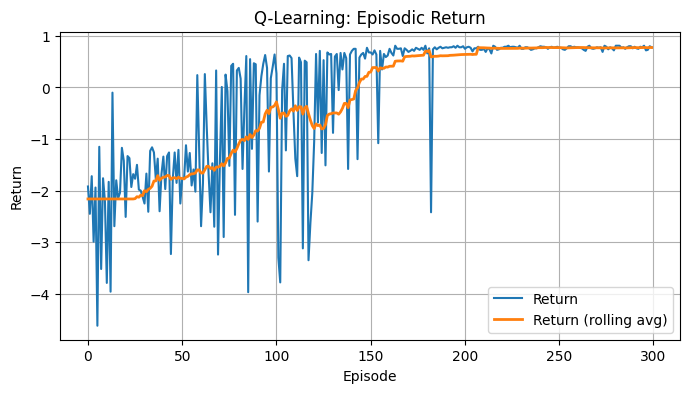

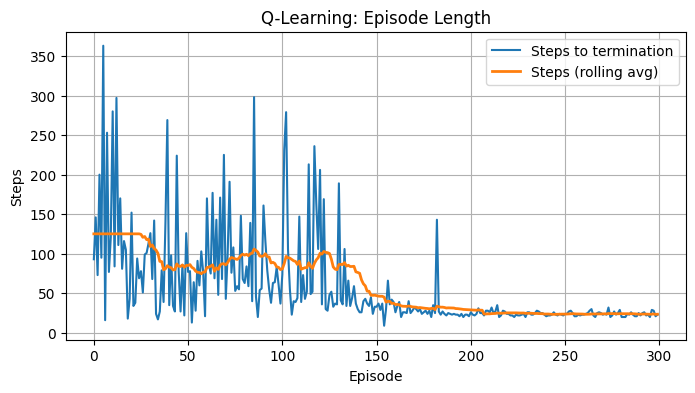

In [24]:
plt.figure(figsize=(8,4))
plt.plot(logs["returns"], label="Return")
plt.plot(rolling(logs["returns"], 25), label="Return (rolling avg)", linewidth=2)
plt.title("Q-Learning: Episodic Return"); plt.xlabel("Episode"); plt.ylabel("Return")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(logs["steps"], label="Steps to termination")
plt.plot(rolling(logs["steps"], 25), label="Steps (rolling avg)", linewidth=2)
plt.title("Q-Learning: Episode Length"); plt.xlabel("Episode"); plt.ylabel("Steps")
plt.grid(True); plt.legend(); plt.show()


### 5) Render snapshot trajectories with your `env.render(...)`

Converts each trajectory of state indices into `(row, col)` and overlay it as a path.
This gives you **several images** across training showing the agent getting better.

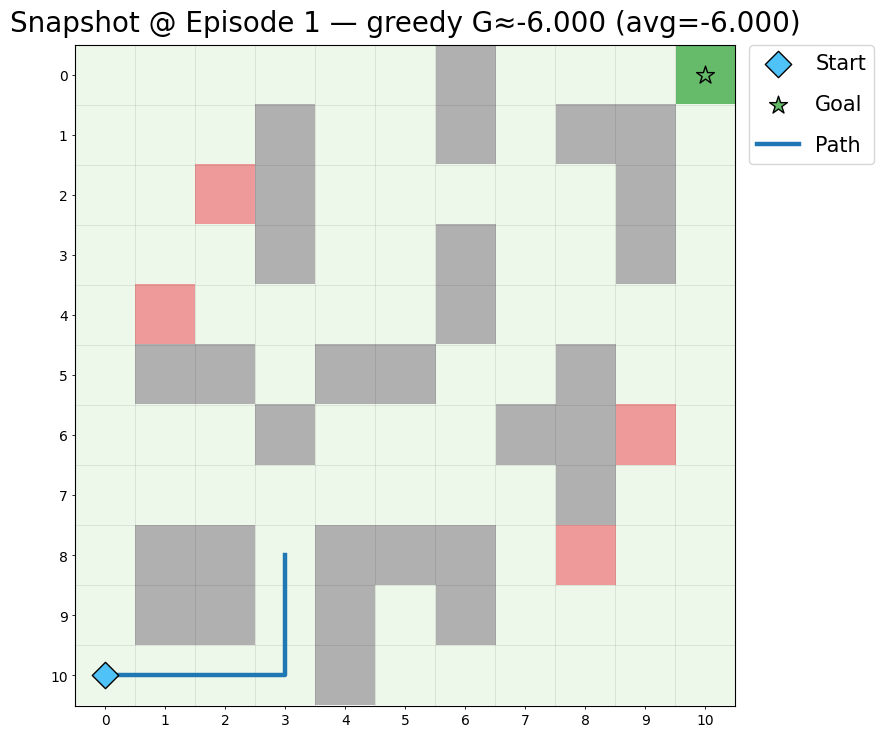

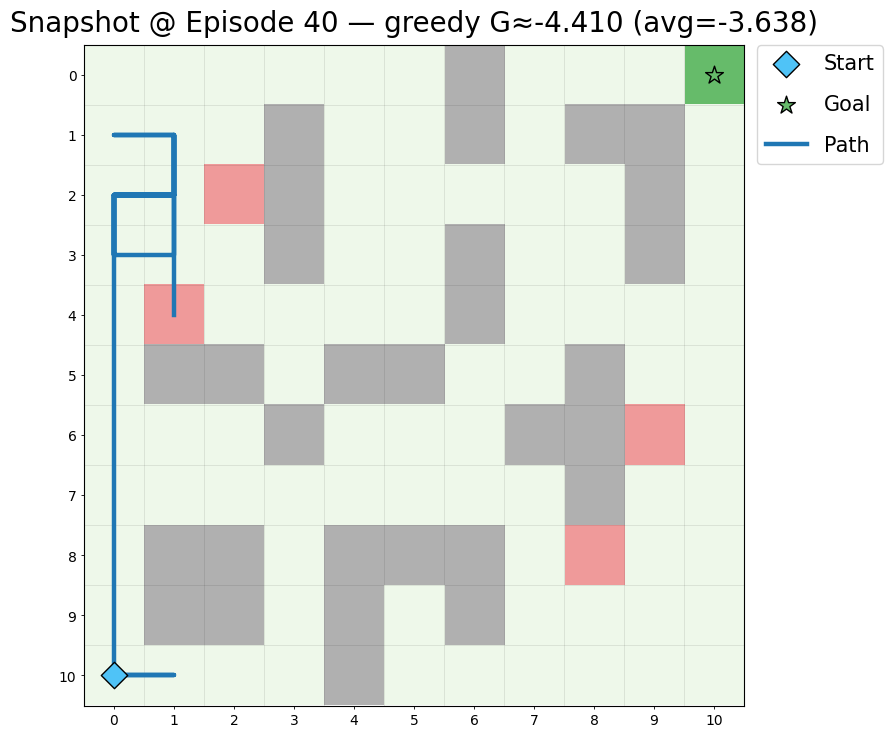

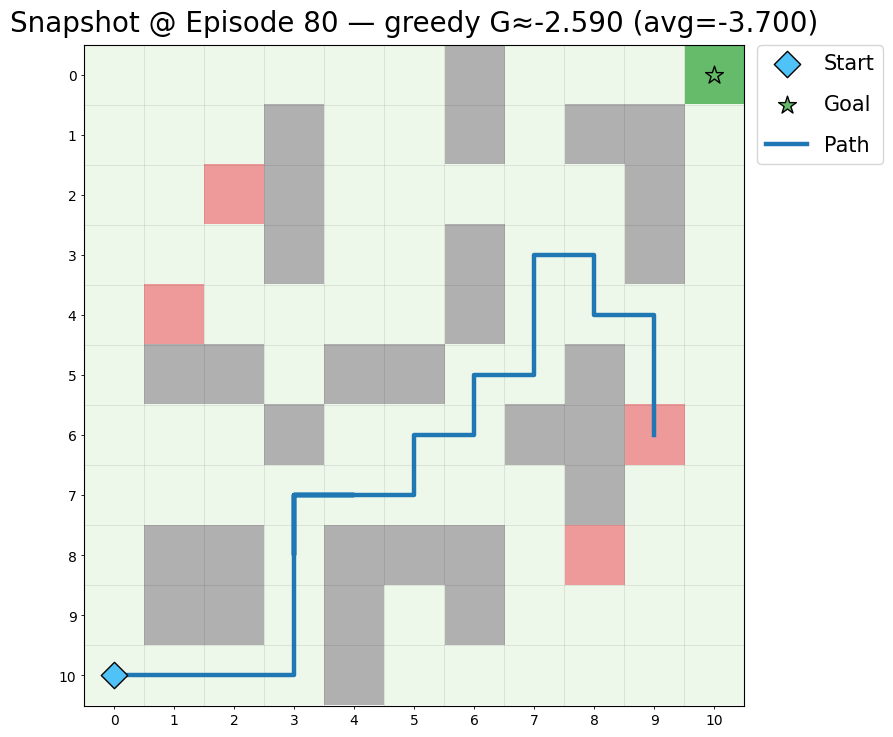

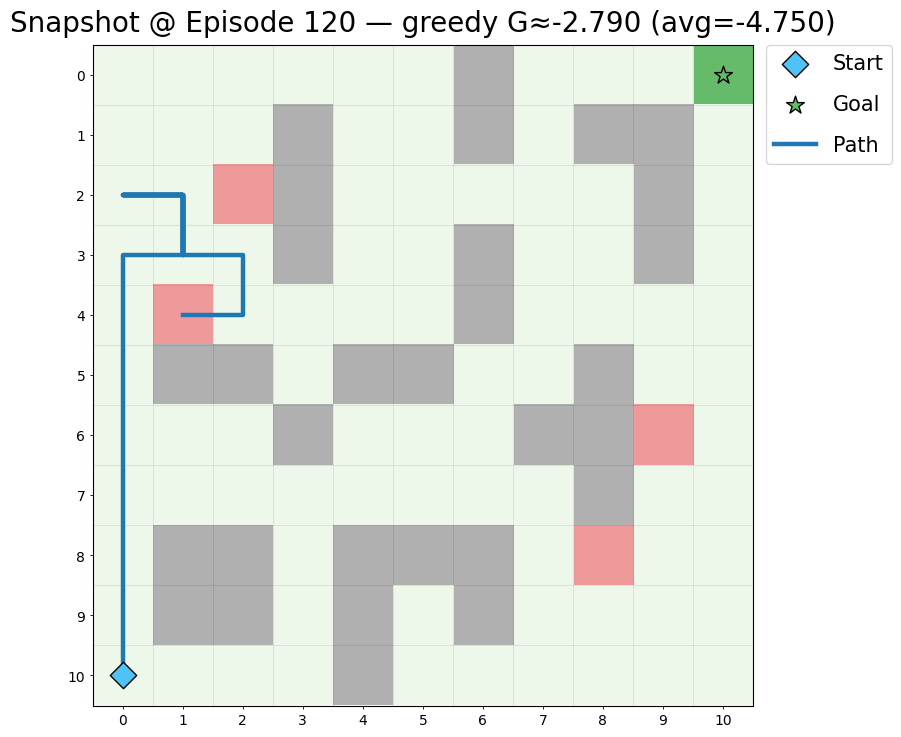

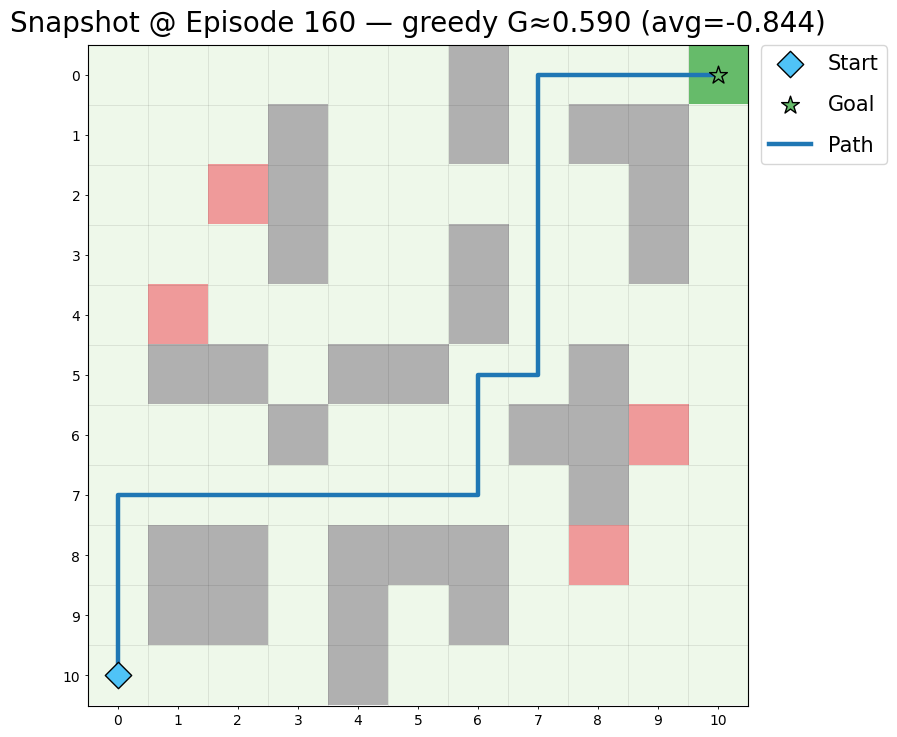

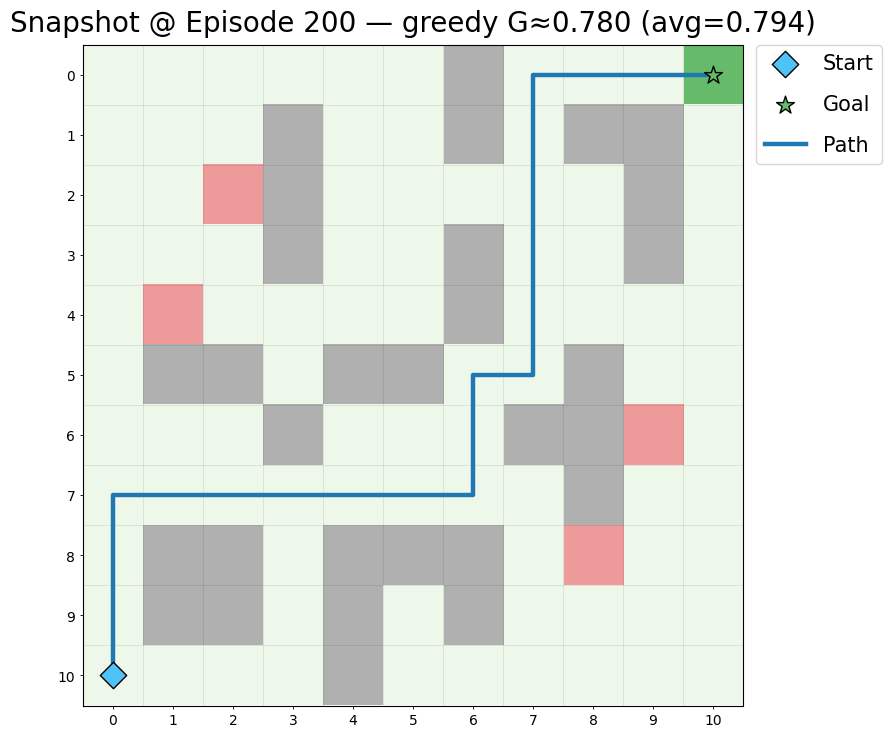

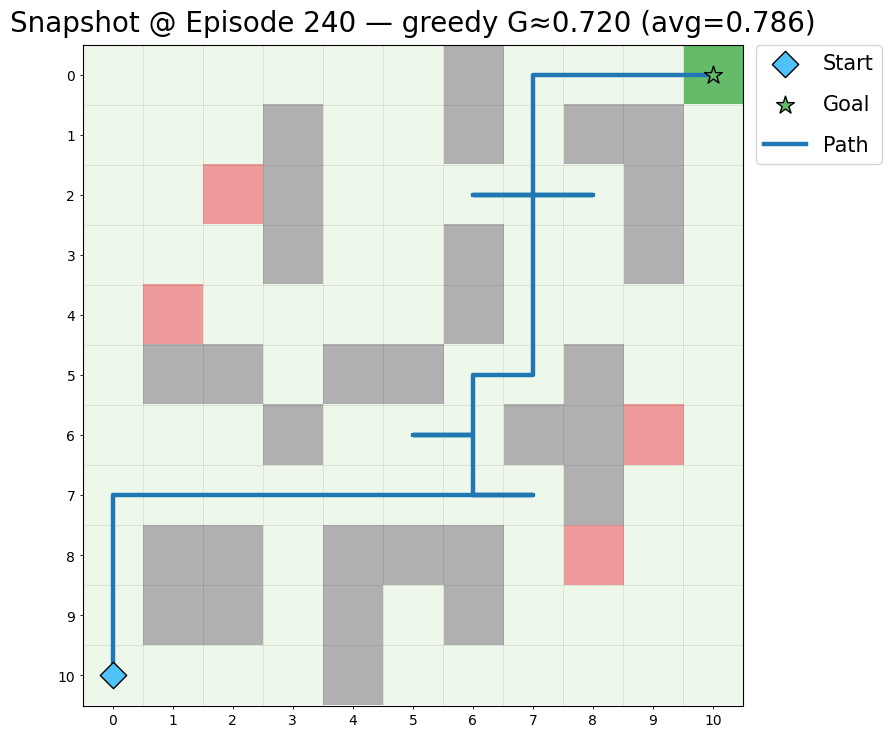

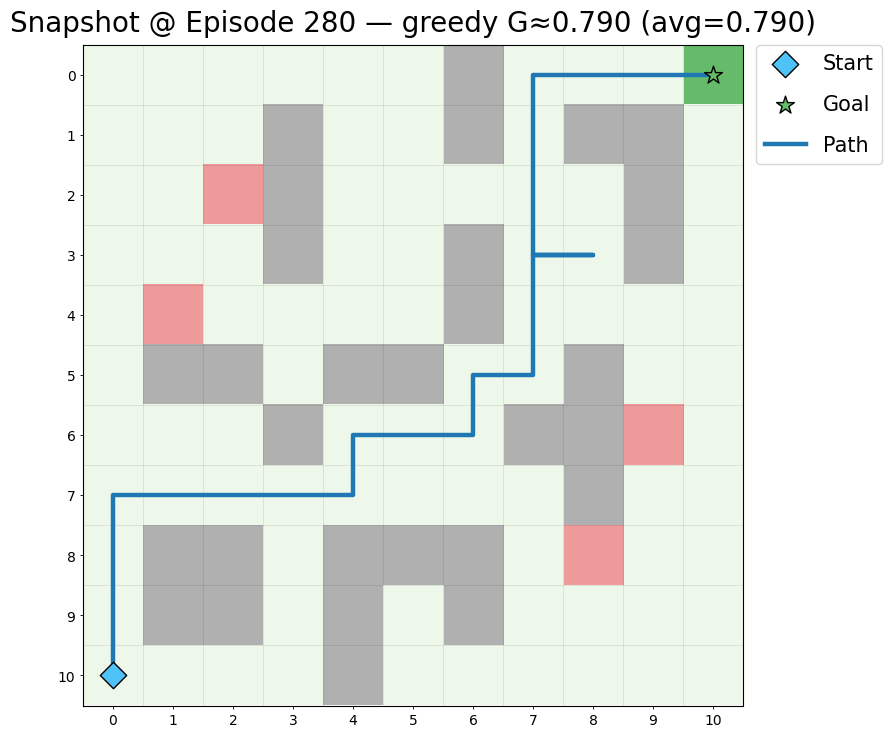

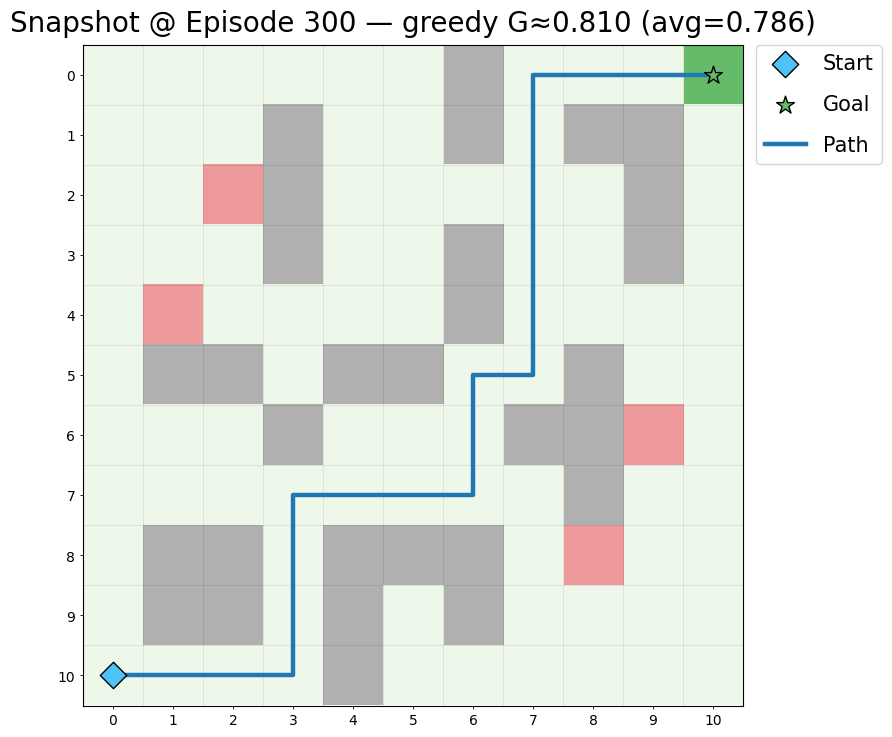

In [32]:
def idx_traj_to_rc_path(env, traj_idx):
    return [idx_to_rc(env, s) for s in traj_idx]

for snap in logs["snapshots"]:
    ep = snap["episode"]
    Q_snap = snap["Q"]
    avg_ret = snap["avg_return"]

    # Run one greedy episode from this snapshot
    G_snap, traj_idx = run_greedy_episode(env, Q_snap, max_steps=cfg.max_steps)
    path_rc = idx_traj_to_rc_path(env, traj_idx)

    env.reset()
    env.render(
        path=path_rc,
        show_agent=False,
        title=f"Snapshot @ Episode {ep} — greedy G≈{G_snap:.3f} (avg={avg_ret:.3f})"
    )


### 6) Final greedy path

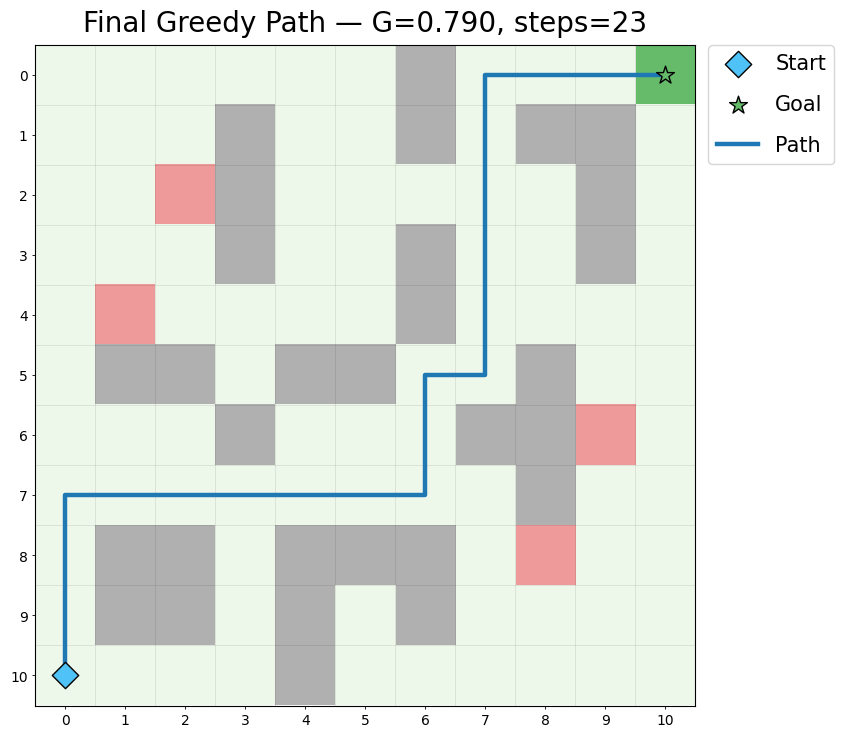

In [33]:
G_final, traj_final = run_greedy_episode(env, Q, max_steps=cfg.max_steps)
env.reset()
env.render(
    path=idx_traj_to_rc_path(env, traj_final),
    show_agent=False,
    title=f"Final Greedy Path — G={G_final:.3f}, steps={len(traj_final)}"
)


### 7) Policy / value heatmap with arrows

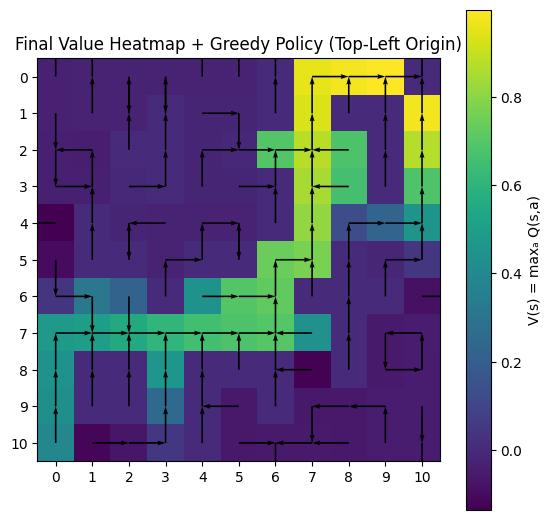

In [34]:
def value_grid(env, Q):
    V = np.max(Q, axis=1)
    G = np.zeros((env.rows, env.cols))
    for s in range(env.num_states):
        r, c = idx_to_rc(env, s)
        G[r, c] = V[s]
    return G

def plot_value_and_policy(env, Q, title="Value & Policy"):
    H, W = env.rows, env.cols
    Vg = value_grid(env, Q)

    plt.figure(figsize=(6.5,6.5))
    # origin='upper' + invert_yaxis() → matches (0,0) at top-left like your render()
    plt.imshow(Vg, origin='upper')
    plt.colorbar(label="V(s) = maxₐ Q(s,a)")
    plt.title(title)
    plt.xticks(range(W))
    plt.yticks(range(H))

    # arrows (0:Up, 1:Right, 2:Down, 3:Left)
    action_to_vec = {0:(-1,0), 1:(0,1), 2:(1,0), 3:(0,-1)}
    X, Y, U, V = [], [], [], []
    for s in range(env.num_states):
        a = int(np.argmax(Q[s]))
        dr, dc = action_to_vec[a]
        r, c = idx_to_rc(env, s)
        X.append(c)
        Y.append(r)
        U.append(dc)
        V.append(dr)   # flipped sign because of inverted axis

    plt.quiver(X, Y, U, V, scale=1, angles='xy', scale_units='xy', width=0.004)
    plt.grid(False)
    plt.show()

plot_value_and_policy(env, Q, title="Final Value Heatmap + Greedy Policy (Top-Left Origin)")


### Conclusion

The results demonstrate the core behavior of **Q_Learning**, gradual improvement in both cumulative return and path efficiency through repeated exploration and value updates.

* **Episodic Return:** Early episodes yield mostly negative returns because the agent explores randomly, often walking into pits, or looping aimlessly. Over time, as the Q-values converge and $\varepsilon$ decays, the agent learns to follow trajectories that reach the goal reliably, raising the return toward the optimal valud of = +1.
  
* **Episode Length:** The number of steps per pisode decreases sharply after roughly 100 - 150 episodes. This shows that the agent no only finds successful routes but also learns to reach the goal faster by avoiding dead ends and unnecessary detours.

* **Final Policy and Value Function:** The heatmap of $V(s) = \max_{a'} \, Q(s, a)$ highlights high-value regions leading directly toward the goal (bright yellow). The greedy policy arrows form a coherent pathway from the start (bottom-left) to the goal (top-right), smoothly navigating around walls and pits, clear evidence of convergence to an optimal policy.

* **Greedy Path Visualization** The final path in the rendered GridWorld confirms this quantitative improvement: the agent travels efficiently from start to goal in only 23 steps, achieving a total return of = 0.79 despite stochastic wind effects.

---

<style>
    .button {
        background-color: #3b3b3b;
        color: white;
        padding: 25px 60px;
        border: none;
        border-radius: 12px;
        cursor: pointer;
        font-size: 30px;
        transition: background-color 0.3s ease;
    }

    .button:hover {
        background-color: #45a049;
        transform: scale(1.05);
    }
    
</style>

<div style=" text-align: center; margin-top:20px;">
    
  <a href="00_RL.ipynb">
    <button class="button">
      ⬅️ Prev: Project Details
    </button>
  </a>
  <span style="display:inline-block; width:200px;"></span>
  <a href="02_sarsa.ipynb">
    <button class="button">
      Next: SARSA ➡️
    </button>
  </a>
  
</div>
